In [2]:
import graph_tool.all as gt
import numpy as np
import networkx as nx
import matplotlib.pylab as plt

In [3]:

def get_prop_type(value, key=None):
    """
    Performs typing and value conversion for the graph_tool PropertyMap class.
    If a key is provided, it also ensures the key is in a format that can be
    used with the PropertyMap. Returns a tuple, (type name, value, key).

    This function is adapted from Benjamin Bengfort's blog post!
    https://bbengfort.github.io/2016/06/graph-tool-from-networkx/
    """
    if isinstance(key, str):  # Keep the key as a string
        key = key  # No encoding necessary in Python 3

    # Deal with the value
    if isinstance(value, bool):
        tname = 'bool'

    elif isinstance(value, int):
        tname = 'float'
        value = float(value)

    elif isinstance(value, float):
        tname = 'float'

    elif isinstance(value, str):
        tname = 'string'
        
    elif isinstance(value, bytes):
        tname = 'bytes'

    elif isinstance(value, dict):
        tname = 'object'

    else:
        tname = 'string'
        value = str(value)

    return tname, value, key


def nx2gt(nxG):
    """
    Converts a networkx graph to a graph-tool graph.
    """
    # Phase 0: Create a directed or undirected graph-tool Graph
    gtG = gt.Graph(directed=nxG.is_directed())

    # Add the Graph properties as "internal properties"
    for key, value in nxG.graph.items():
        # Convert the value and key into a type for graph-tool
        tname, value, key = get_prop_type(value, key)

        prop = gtG.new_graph_property(tname) # Create the PropertyMap
        gtG.graph_properties[key] = prop     # Set the PropertyMap
        gtG.graph_properties[key] = value    # Set the actual value

    # Phase 1: Add the vertex and edge property maps
    # Go through all nodes and edges and add seen properties
    # Add the node properties first
    nprops = set() # cache keys to only add properties once
    for node, data in nxG.nodes(data=True):

        # Go through all the properties if not seen and add them.
        for key, val in data.items():
            if key in nprops: continue # Skip properties already added

            # Convert the value and key into a type for graph-tool
            tname, _, key  = get_prop_type(val, key)

            prop = gtG.new_vertex_property(tname) # Create the PropertyMap
            gtG.vertex_properties[key] = prop     # Set the PropertyMap

            # Add the key to the already seen properties
            nprops.add(key)

    # Also add the node id: in NetworkX a node can be any hashable type, but
    # in graph-tool node are defined as indices. So we capture any strings
    # in a special PropertyMap called 'id' -- modify as needed!
    gtG.vertex_properties['id'] = gtG.new_vertex_property('string')

    # Add the edge properties second
    eprops = set() # cache keys to only add properties once
    for src, dst, data in nxG.edges(data=True):

        # Go through all the edge properties if not seen and add them.
        for key, val in data.items():
            if key in eprops: continue # Skip properties already added

            # Convert the value and key into a type for graph-tool
            tname, _, key = get_prop_type(val, key)

            prop = gtG.new_edge_property(tname) # Create the PropertyMap
            gtG.edge_properties[key] = prop     # Set the PropertyMap

            # Add the key to the already seen properties
            eprops.add(key)

    # Phase 2: Actually add all the nodes and vertices with their properties
    # Add the nodes
    vertices = {} # vertex mapping for tracking edges later
    for node, data in nxG.nodes(data=True):

        # Create the vertex and annotate for our edges later
        v = gtG.add_vertex()
        vertices[node] = v

        # Set the vertex properties, not forgetting the id property
        data['id'] = str(node)
        for key, value in data.items():
            gtG.vp[key][v] = value # vp is short for vertex_properties

    # Add the edges
    for src, dst, data in nxG.edges(data=True):

        # Look up the vertex structs from our vertices mapping and add edge.
        e = gtG.add_edge(vertices[src], vertices[dst])

        # Add the edge properties
        for key, value in data.items():
            gtG.ep[key][e] = value # ep is short for edge_properties

    # Done, finally!
    return gtG

# The Erdos-Renyi example

In [4]:
N = 200
p = 0.01

G = nx.erdos_renyi_graph(N,p)
g = nx2gt(G)

state = gt.minimize_blockmodel_dl(g)

In [5]:
S1 = state.entropy()

for i in range(1000): # this should be sufficiently large
    state.multiflip_mcmc_sweep(beta=np.inf, niter=10)

S2 = state.entropy()

print("Improvement:", S2 - S1)

Improvement: 0.0


# Generating blockmodel networks

In [6]:
import itertools as it

def create_graph_from_e(N, e):
    """
    Creates a graph with N nodes and assigns edges based on a predefined 
    edge budget matrix e1, where the nodes are divided into three blocks.

    The adjacency matrix `e1` specifies the number of edges to add between 
    each pair of blocks. Nodes are partitioned equally into three groups, 
    and edges are randomly assigned between and within these groups based 
    on the values in `e1`.

    Parameters:
    ----------
    N : int
        The total number of nodes in the graph. This should be divisible by 3 
        for an equal partitioning of nodes into three groups.

    Returns:
    -------
    G : networkx.Graph
        A graph object where nodes are partitioned into three groups and edges 
        are added based on the edge budget matrix.
    """

    # Create a graph with N nodes
    G = nx.MultiGraph()
    G.add_nodes_from(list(range(N)))

    # Define partition for the nodes
    num_blocks = len(e)
    partition = []
    for b in range(num_blocks):
        partition = partition + [b]*int(N/num_blocks)
    
    if len(partition)!=N:
        add_nodes = N-len(partition)
        for _ in range(add_nodes):
            partition.append(partition[-1])

    # Loop over the blocks in the partition    
    for block_i in range(e.shape[0]):
        for block_j in range(e.shape[1]):

            # Get nodes belonging to block i and block j            
            nodes_i = [ix for ix,i in enumerate(partition) if i==block_i]
            nodes_j = [ix for ix,i in enumerate(partition) if i==block_j]
            
            # Get the number of edges to add between blocks
            budget_edges = e[block_i, block_j]
            
            # Create all possible edges between nodes in block_i and block_j
            possible_edges = np.array(list(it.product(nodes_i, nodes_j)))
            
            # Randomly select edges based on the budget
            selected_edges_inds = np.random.choice(
                list(range(len(possible_edges))),
                size=budget_edges,
                replace=True # allow repeat edges?
                # replace=False  # Ensure no repeated edges
            )
            selected_edges = possible_edges[selected_edges_inds]

            # Add the selected edges to the graph
            G.add_edges_from(selected_edges)
    
    return G

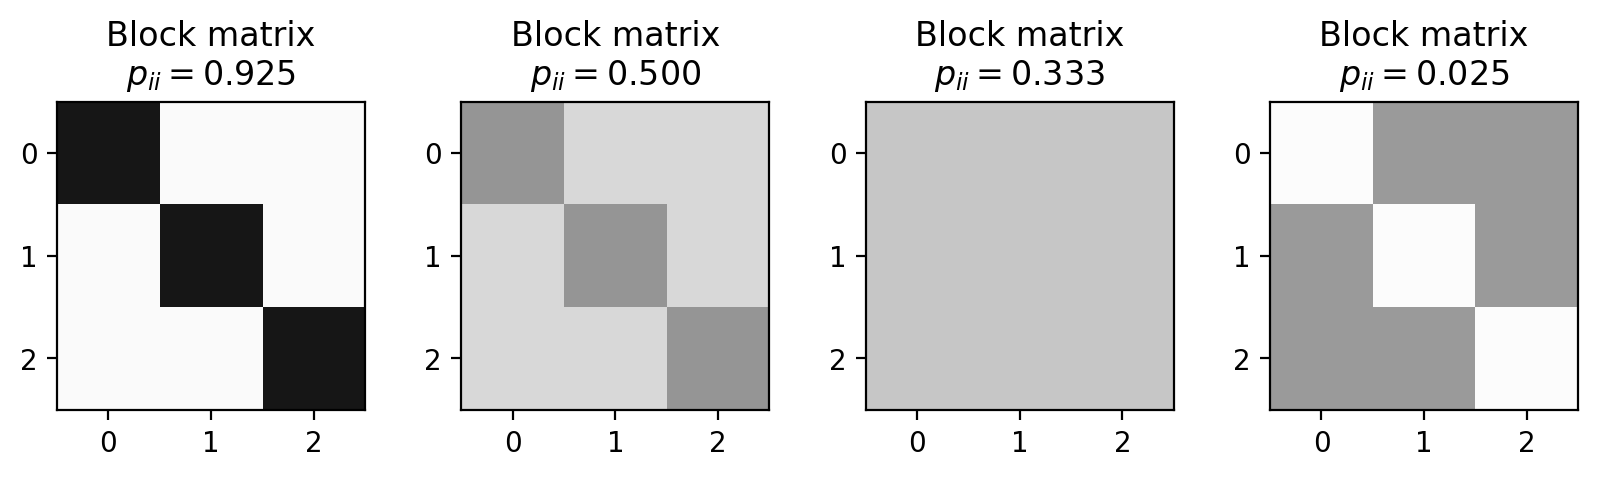

In [7]:
p_ii = 0.925
p_ij = (1-p_ii)/2
block_matrix1 = np.array([[p_ii, p_ij, p_ij], 
                          [p_ij, p_ii, p_ij], 
                          [p_ij, p_ij, p_ii]])

p_ii = 0.5
p_ij = (1-p_ii)/2
block_matrix2 = np.array([[p_ii, p_ij, p_ij], 
                          [p_ij, p_ii, p_ij], 
                          [p_ij, p_ij, p_ii]])

p_ii = 0.3333
p_ij = (1-p_ii)/2
block_matrix3 = np.array([[p_ii, p_ij, p_ij], 
                          [p_ij, p_ii, p_ij], 
                          [p_ij, p_ij, p_ii]])

p_ii = 0.025
p_ij = (1-p_ii)/2
block_matrix4 = np.array([[p_ii, p_ij, p_ij], 
                          [p_ij, p_ii, p_ij], 
                          [p_ij, p_ij, p_ii]])

plot_blocks = [block_matrix1, block_matrix2, block_matrix3, block_matrix4]
pii_list = [0.925, 0.5, 0.3333, 0.025]

fig, ax = plt.subplots(1,4,figsize=(10,2),dpi=200)

for i,b in enumerate(plot_blocks):
    ax[i].imshow(b, vmin=0, vmax=1, cmap='Greys')
    ax[i].set_title('Block matrix\n'+r"$p_{ii} = %.3f$"%(pii_list[i]))


plt.show()

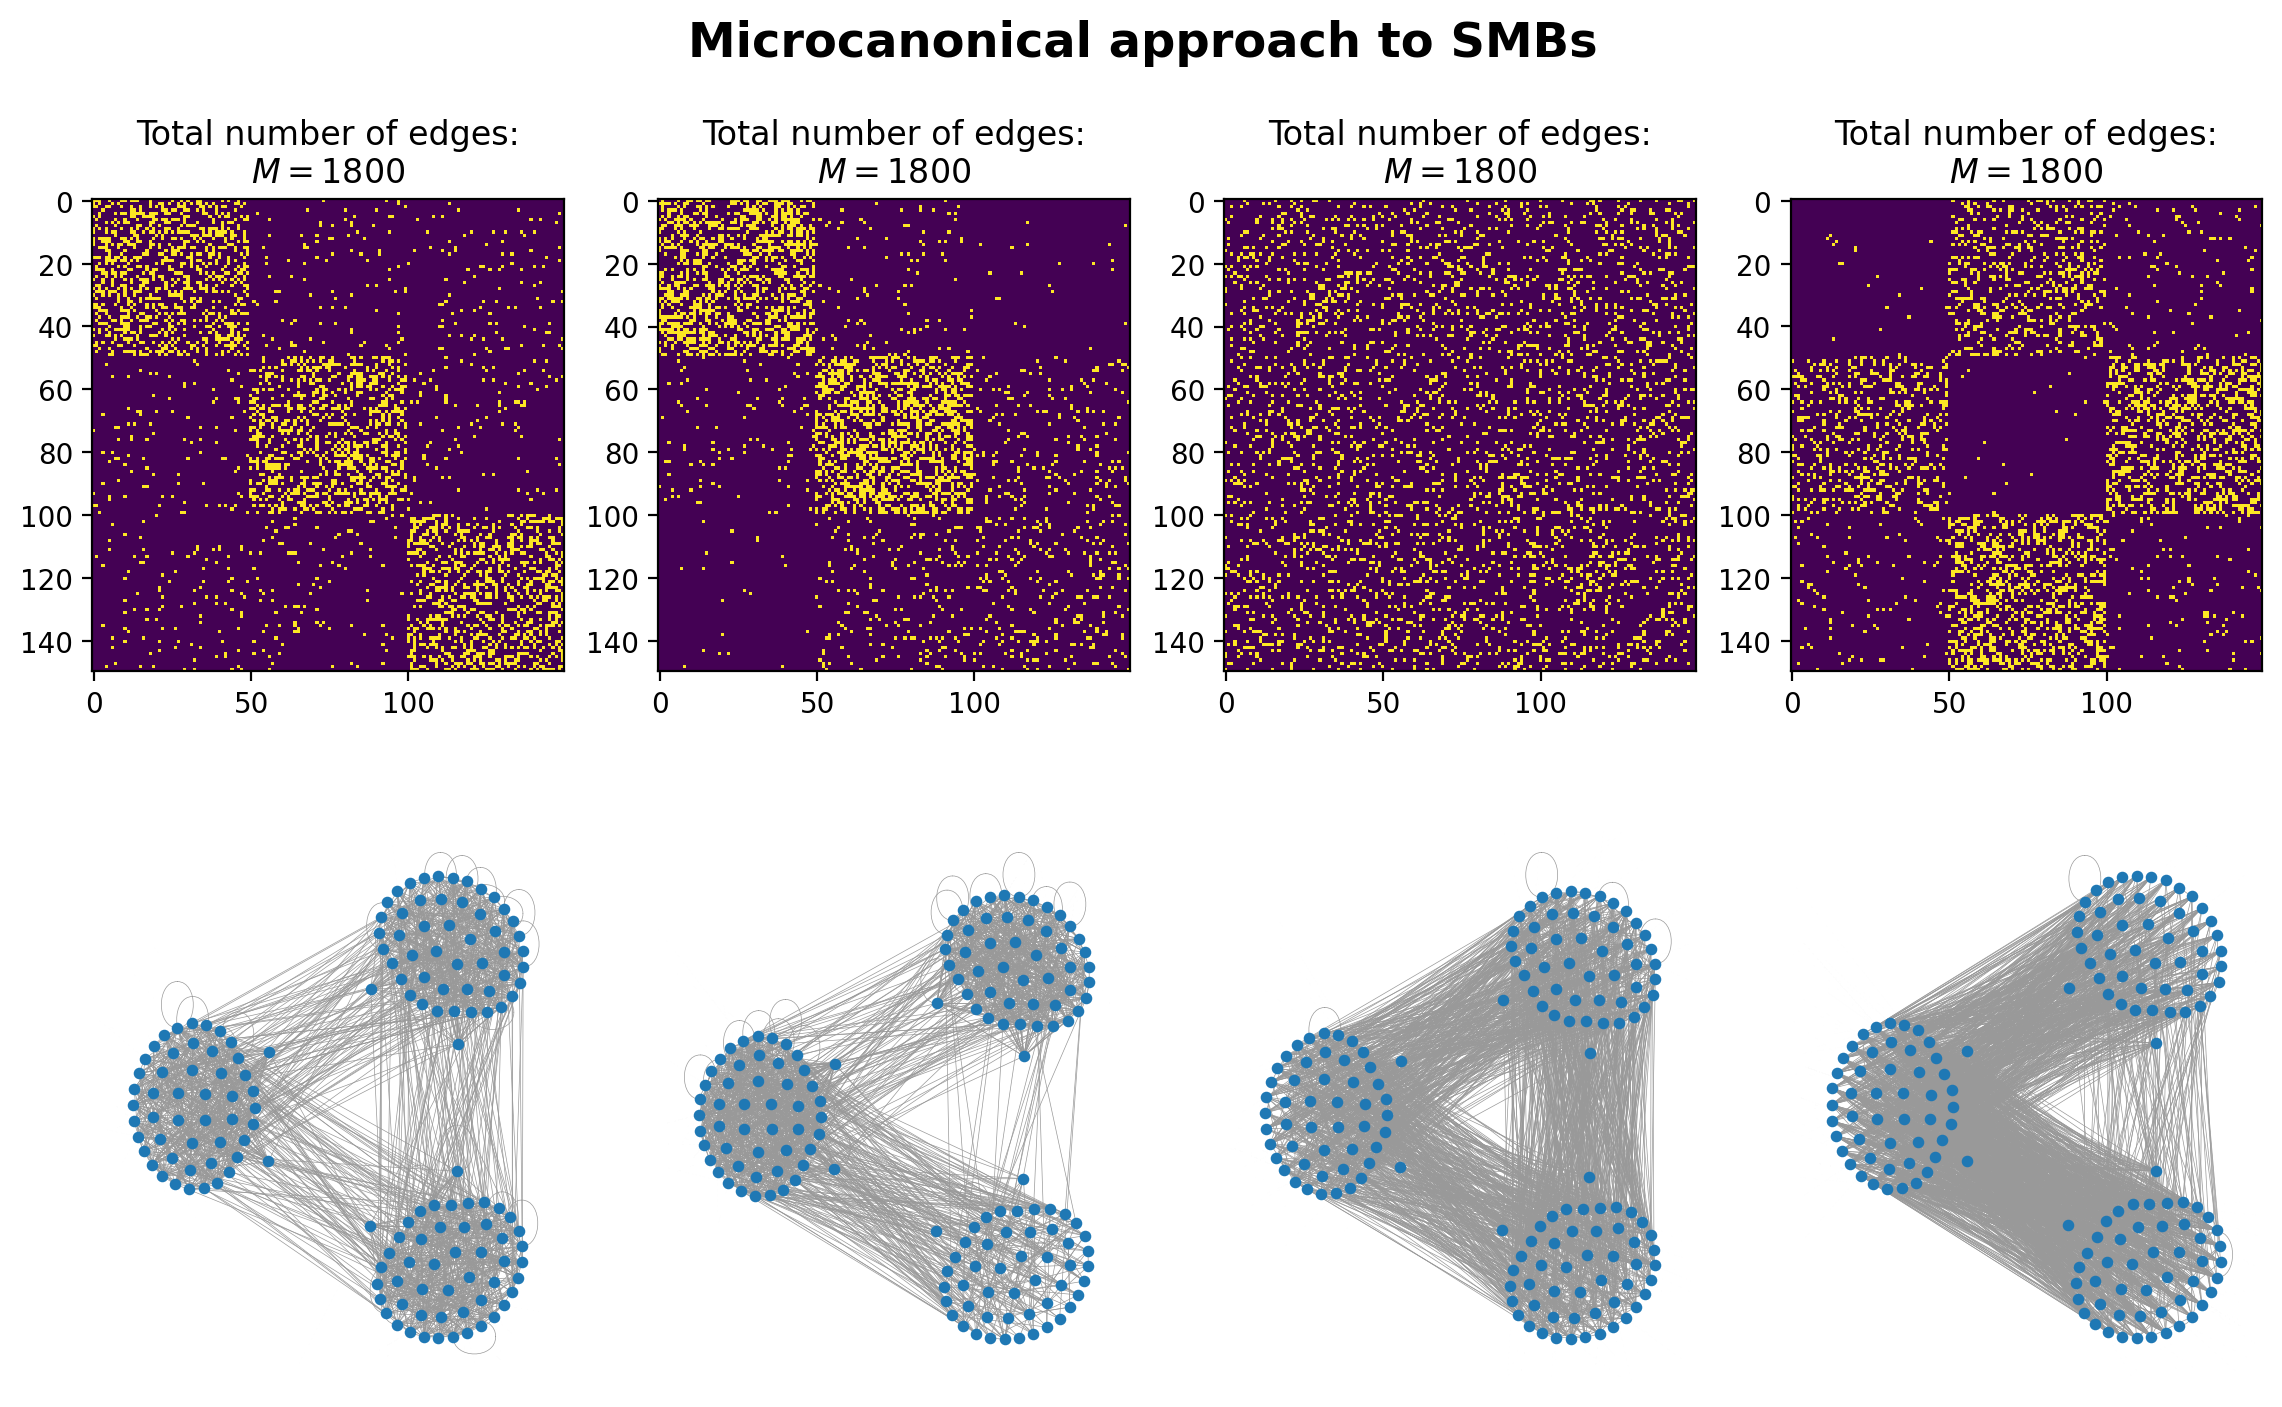

In [8]:
# just for viz purposes, create a layout of the graph we want
N = 150
Gz = nx.ring_of_cliques(3, int(N/3))
pos = nx.kamada_kawai_layout(Gz)


#  matrix of edge counts between blocks
e1 = np.array([[500, 50, 50], 
               [50, 500, 50], 
               [50, 50, 500]])

e2 = np.array([[650, 50, 10], 
               [50, 700, 100], 
               [10, 100, 130]])

e3 = np.array([[200, 200, 200], 
               [200, 200, 200], 
               [200, 200, 200]])

e4 = np.array([[10, 600, 50], 
               [10, 10, 620], 
               [50, 400, 50]])

plot_blocks = [e1,e2,e3,e4]

fig, ax = plt.subplots(2,4,figsize=(14,8),dpi=200)

Gs = []

for x, block_matrix_x in enumerate(plot_blocks):

    Gx = create_graph_from_e(N, block_matrix_x)
    Gs.append(Gx)
    Aij = nx.to_numpy_array(Gx)

    ax[(0,x)].imshow(Aij, vmin=0, vmax=1)
    ax[(0,x)].set_title('Total number of edges:\n'+r"$M = %i$"%(Gx.number_of_edges()))

    nx.draw(Gx, pos=pos, node_size=10, width=0.25, edge_color='.6', ax=ax[(1,x)])

plt.suptitle('Microcanonical approach to SMBs', y=0.965, fontweight='bold', fontsize='xx-large')

plt.show()

First optimize using greedy heuristic, then sample using MCMC

In [9]:
for n, Gx in enumerate(Gs):
    gx = nx2gt(Gx)
    state = gt.minimize_blockmodel_dl(gx)
    
    S1 = state.entropy()

    for i in range(1000): # this should be sufficiently large
        state.multiflip_mcmc_sweep(beta=np.inf, niter=10)

    S2 = state.entropy()

    print("Improvement SMB", n, ":", S2 - S1)
    


Improvement SMB 0 : -23.457545949180712
Improvement SMB 1 : -198.09848033909475
Improvement SMB 2 : 0.0
Improvement SMB 3 : -22.66399102417654


# Real-world network

In [10]:
g = gt.collection.data["celegansneural"]

state = gt.minimize_nested_blockmodel_dl(g)

S1 = state.entropy()

for i in range(1000): # this should be sufficiently large
    state.multiflip_mcmc_sweep(beta=np.inf, niter=10)

S2 = state.entropy()

print("Improvement:", S2 - S1)

Improvement: -145.14828235558343


### Simulated annealing

In [11]:
g = gt.collection.data["celegansneural"]

state = gt.minimize_nested_blockmodel_dl(g)

gt.mcmc_anneal(state, beta_range=(1, 10), niter=1000, mcmc_equilibrate_args=dict(force_niter=10))

(8481.782118267187, 6109998, 930212)

In [12]:
S3 = state.entropy()

print("Further improvement:", S3 - S2)

Further improvement: -15.56467932234591


## Sampling from the posterior distribution

In [13]:
g = gt.collection.data["lesmis"]

state = gt.BlockState(g)   # This automatically initializes the state with a partition
                           # into one group. The user could also pass a higher number
                           # to start with a random partition of a given size, or pass a
                           # specific initial partition using the 'b' parameter.

# Now we run 1,000 sweeps of the MCMC. Note that the number of groups
# is allowed to change, so it will eventually move from the initial
# value of B=1 to whatever is most appropriate for the data.

dS, nattempts, nmoves = state.multiflip_mcmc_sweep(niter=1000)

print("Change in description length:", dS)
print("Number of accepted vertex moves:", nmoves)

Change in description length: -87.46601693291048
Number of accepted vertex moves: 114383


In [14]:
# We will accept equilibration if 10 sweeps are completed without a
# record breaking event, 2 consecutive times.

gt.mcmc_equilibrate(state, wait=10, nbreaks=2, mcmc_args=dict(niter=10))

(716.8092380912498, 170679, 41398)

In [15]:
# We will first equilibrate the Markov chain
gt.mcmc_equilibrate(state, wait=1000, mcmc_args=dict(niter=10))

bs = [] # collect some partitions

def collect_partitions(s):
   global bs
   bs.append(s.b.a.copy())

# Now we collect partitions for exactly 100,000 sweeps, at intervals
# of 10 sweeps:
gt.mcmc_equilibrate(state, force_niter=10000, mcmc_args=dict(niter=10),
                    callback=collect_partitions)

# Disambiguate partitions and obtain marginals
pmode = gt.PartitionModeState(bs, converge=True)
pv = pmode.get_marginal(g)

# Now the node marginals are stored in property map pv. We can
# visualize them as pie charts on the nodes:
state.draw(pos=g.vp.pos, vertex_shape="pie", vertex_pie_fractions=pv,
           output="lesmis-sbm-marginals.svg")

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x32bc8f4d0, at 0x32a6dbaf0>

In [16]:
h = np.zeros(g.num_vertices() + 1)

def collect_num_groups(s):
    B = s.get_nonempty_B()
    h[B] += 1

# Now we collect partitions for exactly 100,000 sweeps, at intervals
# of 10 sweeps:
gt.mcmc_equilibrate(state, force_niter=10000, mcmc_args=dict(niter=10),
                    callback=collect_num_groups)

(723.8461555547804, 50013626, 12694562)

### Heirarchical model

In [17]:
g = gt.collection.data["lesmis"]

state = gt.NestedBlockState(g)   # By default this creates a state with an initial single-group
                                 # hierarchy of depth ceil(log2(g.num_vertices()).

# Now we run 1000 sweeps of the MCMC

dS, nmoves = 0, 0
for i in range(100):
    ret = state.multiflip_mcmc_sweep(niter=10)
    dS += ret[0]
    nmoves += ret[1]

print("Change in description length:", dS)
print("Number of accepted vertex moves:", nmoves)

Change in description length: -77.09360331791115
Number of accepted vertex moves: 498707


In [18]:
# We will first equilibrate the Markov chain
gt.mcmc_equilibrate(state, wait=1000, mcmc_args=dict(niter=10))

# collect nested partitions
bs = []

def collect_partitions(s):
   global bs
   bs.append(s.get_bs())

# Now we collect the marginals for exactly 100,000 sweeps
gt.mcmc_equilibrate(state, force_niter=10000, mcmc_args=dict(niter=10),
                    callback=collect_partitions)

# Disambiguate partitions and obtain marginals
pmode = gt.PartitionModeState(bs, nested=True, converge=True)
pv = pmode.get_marginal(g)

# Get consensus estimate
bs = pmode.get_max_nested()

state = state.copy(bs=bs)

# We can visualize the marginals as pie charts on the nodes:
state.draw(vertex_shape="pie", vertex_pie_fractions=pv,
           output="lesmis-nested-sbm-marginals.svg")

(<VertexPropertyMap object with value type 'vector<double>', for Graph 0x32bc8f4d0, at 0x32bce1a90>,
 <GraphView object, directed, with 85 vertices and 84 edges, edges filtered by <EdgePropertyMap object with value type 'bool', for Graph 0x340578190, at 0x32bce1400>, vertices filtered by <VertexPropertyMap object with value type 'bool', for Graph 0x340578190, at 0x32bce3620>, at 0x340578190>,
 <VertexPropertyMap object with value type 'vector<double>', for Graph 0x340578190, at 0x32bce0910>)

In [19]:
h = [np.zeros(g.num_vertices() + 1) for s in state.get_levels()]

def collect_num_groups(s):
    for l, sl in enumerate(s.get_levels()):
       B = sl.get_nonempty_B()
       h[l][B] += 1

# Now we collect the marginal distribution for exactly 100,000 sweeps
gt.mcmc_equilibrate(state, force_niter=10000, mcmc_args=dict(niter=10),
                    callback=collect_num_groups)

(723.0083797682305, 45642611, 9957314)

In [20]:
for i in range(10):
    for j in range(100):
        state.multiflip_mcmc_sweep(niter=10)
    state.draw(output="lesmis-partition-sample-%i.svg" % i, empty_branches=False)

## Modes of the posterior distribution

In [21]:
g = gt.collection.data["lesmis"]

state = gt.NestedBlockState(g)

# Equilibration
gt.mcmc_equilibrate(state, force_niter=1000, mcmc_args=dict(niter=10))

bs = []

def collect_partitions(s):
   global bs
   bs.append(s.get_bs())

# We will collect only partitions 1000 partitions. For more accurate
# results, this number should be increased.
gt.mcmc_equilibrate(state, force_niter=1000, mcmc_args=dict(niter=10),
                    callback=collect_partitions)

# Infer partition modes
pmode = gt.ModeClusterState(bs, nested=True)

# Minimize the mode state itself
gt.mcmc_equilibrate(pmode, wait=1, mcmc_args=dict(niter=1, beta=np.inf))

# Get inferred modes
modes = pmode.get_modes()

for i, mode in enumerate(modes):
    b = mode.get_max_nested()    # mode's maximum
    pv = mode.get_marginal(g)    # mode's marginal distribution

    print(f"Mode {i} with size {mode.get_M()/len(bs)}")
    state = state.copy(bs=b)
    state.draw(vertex_shape="pie", vertex_pie_fractions=pv,
               output="lesmis-partition-mode-%i.svg" % i)

Mode 0 with size 0.7207207207207207
Mode 1 with size 0.2072072072072072
Mode 2 with size 0.07007007007007007
Mode 3 with size 0.002002002002002002
